In [1]:
import numpy as np
import sys
sys.path.append("/home2/ebrahim/beyond-brainscore/analyze_results/figures_code")
from trained_untrained_results_funcs import find_best_layer, elementwise_max, custom_add_2d, load_perf, loop_through_datasets
from untrained_results_funcs import load_untrained_data
from plotting_functions import plot_across_subjects, load_into_3d, save_nii, plot_2d_hist_scatter_updated
from matplotlib import pyplot as plt
from stats_funcs import compute_paired_ttest
import pandas as pd
import seaborn as sns
from nilearn import plotting
import matplotlib

resultsPath_base = '/data/LLMs/brainscore/'
figurePath = 'figures/new_figures/figure4/'

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in ['243', '384']:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()
lang_indices_dict = {}
lang_indices_dict['384'] = lang_indices_384
lang_indices_dict['243'] = lang_indices_243

subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)
subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
subjects_dict_all = {'pereira': subjects_dict, 'fedorenko': subjects_arr_fed, 'blank': subjects_arr_blank}

networks_dict_all = {'pereira': br_labels_dict, 'fedorenko': np.repeat('language', len(subjects_arr_fed)), 
                      'blank': np.repeat('language', len(subjects_arr_blank))}




In [2]:
def select_lang_voxels(network_arr, subject_arr, model_perf):
    
    # check if there are non-lang voxels
    if np.unique(network_arr).shape[0] > 0:
        lang_indices = np.argwhere(network_arr=='language').squeeze()
        # check if there are perf values corresponding to those non-lang voxels
        if model_perf.shape[0] == network_arr.shape[0]:
            return network_arr[lang_indices], subject_arr[lang_indices], model_perf[lang_indices]
        else:
            return network_arr[lang_indices], subject_arr[lang_indices], model_perf
    
    return network_arr, subject_arr, model_perf
    
def load_model_data_into_df(model_names, plot_names, dataset_list, exp_list, 
                            subjects_dict, networks_dict, perf):

    results = {'perf':[], 'subjects': [], 'Network': [], 
                                        'Model': []}
    
    if dataset_list[0] == 'pereira':
        results['Exp'] = []

    for mn, pn, dataset, exp in zip(model_names, plot_names, dataset_list, exp_list):
        
        model_res = np.load(f"/data/LLMs/brainscore/results_{dataset}/{dataset}_{mn}.npz")[perf]
            
        subjects = subjects_dict[dataset]
        networks = networks_dict[dataset]

        if len(exp) > 0:
            subjects = subjects[exp]
            networks = networks[exp]
            
        
        networks, subjects, model_res = select_lang_voxels(networks, subjects, model_res)
        
        
        results['perf'].extend(model_res)
        results['subjects'].extend(subjects)
        results['Network'].extend(networks)
        results['Model'].extend(np.repeat(pn, len(model_res)))
        if dataset == 'pereira':
            results['Exp'].extend(np.repeat(exp.strip('_'), len(model_res)))

    
    return pd.DataFrame(results)

In [3]:
perf_metric = 'pearson_r'
simple_color = sns.color_palette("Greens", 5)[3]  
color_palette = ['gray', 'blue', 'black', 'orange', 'purple', simple_color, 'pink', 'red']

In [4]:
best_layers_pereira = np.load('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/best_layer_sigma_info/best_layer_other_pereira.npz')

model_names_pereira = ['trained-var-par_384-sp_WN_1_384', 'trained-var-par_243-sp_WN_1_243', 'position_layer_1.2_1_384', 'position_layer_0.5_1_243', 
              'positional_WN_smooth_layer_1.2_1_384', 'positional_WN_smooth_layer_0.5_1_243', 'trained-var-par_384-sp_glove_1_384', 'trained-var-par_243-sp_glove_1_243', 
              'glove-sp_PWR_384_layer_1_1000_384', 'glove-sp_PWR_243_layer_1_1000_243', 
              'gpt2-xl_layer_21_1_384', 'gpt2-xl_layer_15_1_243',
              'gpt2-xl-mp_layer_21_1_384', 'gpt2-xl-mp_layer_16_1_243',
              'gpt2-xl-sp_layer_16_1_384', 'gpt2-xl-sp_layer_16_1_243']

plot_names_pereira = ['WR', 'WR', 'P', 'P', 'PWR', 'PWR', 'GloVe', 'GloVe', 'Simple', 
                      'Simple', 'GPT2XL', 'GPT2XL', 'GPT2XL-MP', 'GPT2XL-MP', 'GPT2XL-SP', 'GPT2XL-SP']

simple_color = sns.color_palette("Greens", 5)[3]  
color_palette = ['gray', 'blue', 'black', 'orange', 'purple', simple_color, 'pink', 'red']
dataset_list = np.repeat('pereira', len(model_names_pereira))
exp_list = np.tile(['384', '243'], int(len(model_names_pereira)/2))

results_pereira = load_model_data_into_df(model_names_pereira, plot_names_pereira, dataset_list, exp_list, 
                            subjects_dict_all, networks_dict_all, perf=perf_metric)

results_pd_pereira_243 = results_pereira.loc[results_pereira.Exp=='243']
results_pd_pereira_384 = results_pereira.loc[results_pereira.Exp=='384']


pereira_model_list = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'Simple']
results_pereira_plot = results_pereira.loc[results_pereira['Model'].isin(pereira_model_list)]



model_names_fedorenko = ['gpt2-xl_layer_25_1', 'gpt2-xl-mp_layer_25_1', 'gpt2-xl-sp_layer_21_1', 'glove-sp_PWR_layer_1_1000', 'pos_layer_4.3_1', 'pos_layer_4.3_1', 'zeros_layer_0_1', 'glove-sp_layer_0_1']
plot_names_fedorenko = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'PWR+GloVe', 'PWR', 'Simple', 'WR', 'GloVe']
dataset_list = np.repeat('fedorenko', len(model_names_fedorenko))
exp_list = np.repeat('', len(model_names_fedorenko))
results_fedorenko = load_model_data_into_df(model_names_fedorenko, plot_names_fedorenko, dataset_list, exp_list, 
                            subjects_dict_all, networks_dict_all, perf=perf_metric)

fedorenko_model_list = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'Simple']
results_fedorenko_plot = results_fedorenko.loc[results_fedorenko['Model'].isin(fedorenko_model_list)]


model_names_blank = ['gpt2-xl_layer_2_1', 'gpt2-xl-mp_layer_3_1', 'gpt2-xl-sp_layer_2_1',
                     'glove-sp_PWR_layer_1_1000', 'pos-WN_layer_12_1', 'pos_layer_12_1',  'trained-var-par-sp_WN_1', 'glove-sp_layer_0_1']

plot_names_blank = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'PWR+GloVe', 'Simple', 'P', 'WR', 'GloVe']

dataset_list = np.repeat('blank', len(model_names_blank))
exp_list = np.repeat('', len(model_names_blank))

results_blank = load_model_data_into_df(model_names_blank, plot_names_blank, dataset_list, exp_list, 
                            subjects_dict_all, networks_dict_all, perf=perf_metric)


blank_model_list = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'Simple']
results_blank_plot = results_blank.loc[results_blank['Model'].isin(blank_model_list)]



results_pd_dict = {'pereira': results_pereira_plot,
                   'fedorenko': results_fedorenko_plot, 'blank': results_blank_plot}

/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/plotting_functions.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_pd_merged['perf'] = np.nan_to_num(dict_pd_merged['perf'])
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/plotting_functions.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Taking mean value across voxels with a participant
Taking mean value across voxels with a participant
Taking mean value across voxels with a participant


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


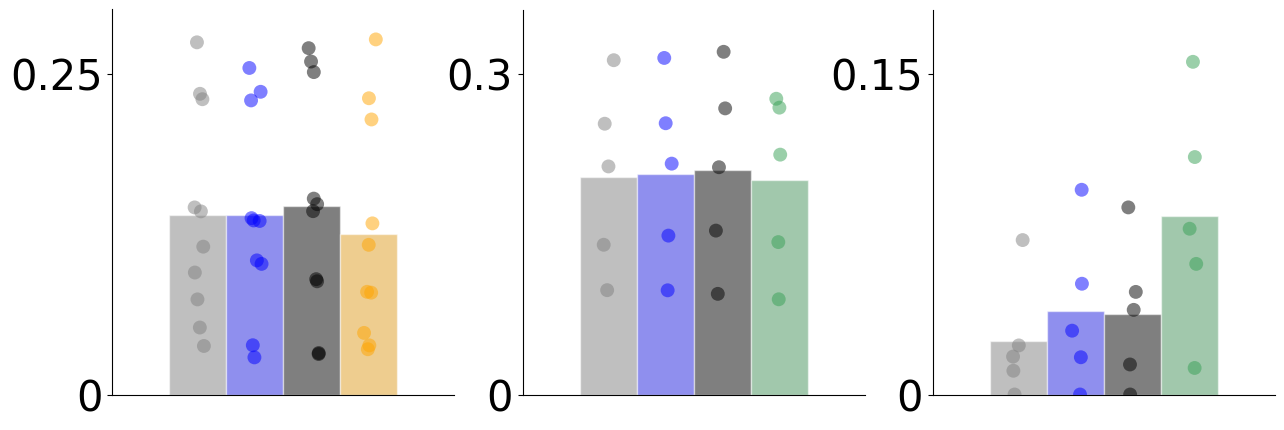

In [5]:
hue_order = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'Simple']
color_palette = ['gray', 'blue', 'black', 'orange', '#5C4033', simple_color, 'pink', 'red']
yticks_perf_dict = {'pereira': [0,.25],'fedorenko': [0, 0.30], 'blank': [0,0.15]}
perf_metric = 'pearson_r'
figurePath = ''
saveName = 'scratch'
median = False 
clip_zero = False
plot_xlabel = False

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, d in enumerate(['pereira', 'fedorenko', 'blank']):
    
    results_pd = results_pd_dict[d]
    ax_select = ax[i]
    
    if d == 'pereira':
        color_palette_reduced = ['gray', 'blue', 'black', 'orange']
    else:
        color_palette_reduced = ['gray', 'blue', 'black', simple_color]
        
    
    
    subject_avg_pd, dict_pd_merged, dict_pd_with_all = plot_across_subjects(results_pd, figurePath=figurePath,  selected_networks=['language'],
                                                                dataset=d, saveName=f'{d}', order=['language'], clip_zero=clip_zero, 
                                                                draw_lines=False, ms=10, plot_legend=False,  
                                                                plot_legend_under=False, width=0.7, median=median, ylabel_str='', legend_fontsize=30, ax_select=ax_select,
                                                                remove_yaxis=False, plot_xlabel=plot_xlabel, alpha=0.5,
                                                                yticks=yticks_perf_dict[d], 
                                                                hue_order=hue_order, color_palette=color_palette_reduced)

subject_avg_pd = subject_avg_pd.reset_index()
fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/model_comp/{perf_metric}.png")
fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/model_comp/{perf_metric}.pdf", bbox_inches='tight')

In [6]:
hue_order = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'Simple', 'GloVe', 'PWR', 'P', 'WR']

/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/plotting_functions.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_pd_merged['perf'] = np.nan_to_num(dict_pd_merged['perf'])
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/plotting_functions.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Taking mean value across voxels with a participant
Taking mean value across voxels with a participant


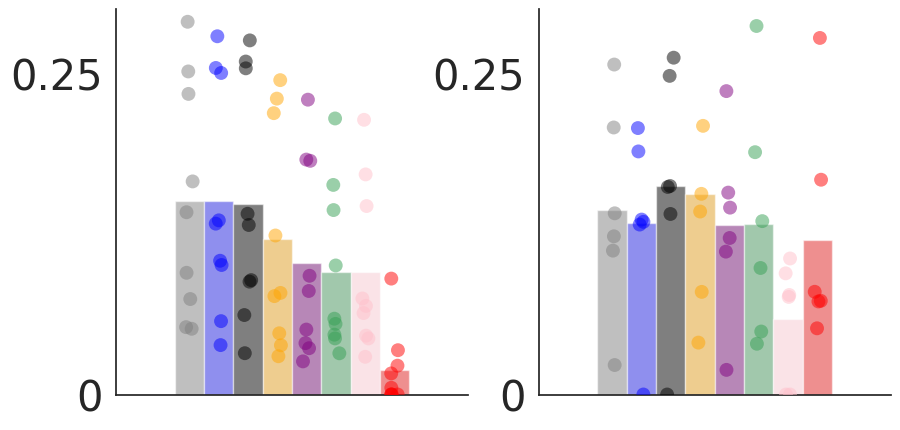

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
d = 'pereira'
fe = ''
perf_str = ''

subj_243, _, _ = plot_across_subjects(results_pd_pereira_243, figurePath=figurePath,  selected_networks=['language'],
                                                            dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, 
                                                            draw_lines=False, ms=10, plot_legend=False,  
                                                            plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax[1],
                                                            remove_yaxis=False, plot_xlabel=plot_xlabel, alpha=0.5,
                                                            yticks=yticks_perf_dict[d], 
                                                            hue_order=hue_order, color_palette=color_palette)

subj_384, _, _ = plot_across_subjects(results_pd_pereira_384, figurePath=figurePath,  selected_networks=['language'],
                                                            dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, 
                                                            draw_lines=False, ms=10, plot_legend=False,  
                                                            plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax[0],
                                                            remove_yaxis=False, plot_xlabel=plot_xlabel, alpha=0.5,
                                                            yticks=yticks_perf_dict[d], 
                                                            hue_order=hue_order, color_palette=color_palette)

perf = perf_metric
fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/model_comp/{perf}_pereira_exp.png")
fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/model_comp/{perf}_pereira_exp.pdf", bbox_inches='tight')

/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/plotting_functions.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_pd_merged['perf'] = np.nan_to_num(dict_pd_merged['perf'])
/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/plotting_functions.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Taking mean value across voxels with a participant
Taking mean value across voxels with a participant


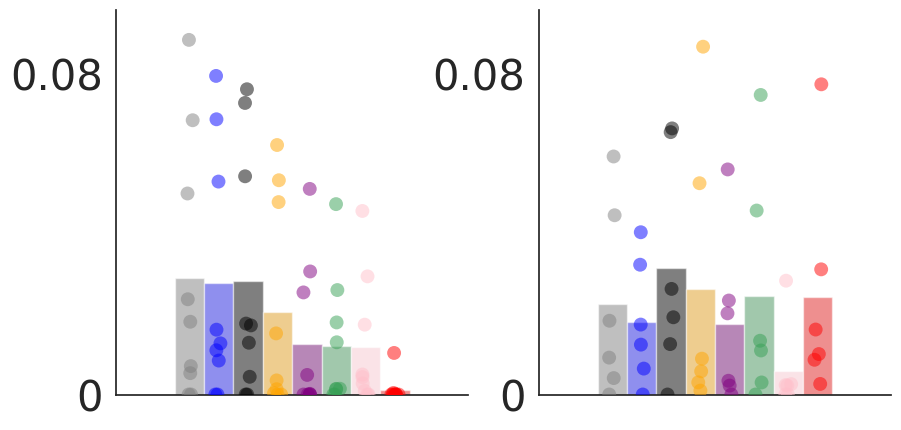

In [80]:
perf_metric = 'out_of_sample_r2'
hue_order = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'Simple', 'GloVe', 'PWR', 'P', 'WR']
yticks_perf_dict = {'pereira': [0,.08]}

model_names_pereira = ['trained-var-par_384-sp_WN_1_384', 'trained-var-par_243-sp_WN_1_243', 
                       'trained-var-par_384-sp_pos_1_384', 'trained-var-par_243-sp_pos_1_243', 
                       'trained-var-par_384-sp_WN+pos_1_384', 'trained-var-par_243-sp_WN+pos_1_243', 
                       'trained-var-par_384-sp_glove_1_384', 'trained-var-par_243-sp_glove_1_243', 
                       'trained-var-par_384-sp_WN+pos+glove_1000_384', 'trained-var-par_243-sp_WN+pos+glove_1000_243', 
                       'gpt2-xl_layer_21_1_384', 'gpt2-xl_layer_16_1_243',
                       'gpt2-xl-mp_layer_21_1_384', 'gpt2-xl-mp_layer_17_1_243',
                       'gpt2-xl-sp_layer_21_1_384', 'gpt2-xl-sp_layer_16_1_243']

plot_names_pereira = ['WR', 'WR', 'P', 'P', 'PWR', 'PWR', 'GloVe', 'GloVe', 'Simple', 
                      'Simple', 'GPT2XL', 'GPT2XL', 'GPT2XL-MP', 'GPT2XL-MP', 'GPT2XL-SP', 'GPT2XL-SP']

simple_color = sns.color_palette("Greens", 5)[3]  
color_palette = ['gray', 'blue', 'black', 'orange', 'purple', simple_color, 'pink', 'red']
dataset_list = np.repeat('pereira', len(model_names_pereira))
exp_list = np.tile(['384', '243'], int(len(model_names_pereira)/2))

results_pereira = load_model_data_into_df(model_names_pereira, plot_names_pereira, dataset_list, exp_list, 
                            subjects_dict_all, networks_dict_all, perf=perf_metric)

results_pd_pereira_243 = results_pereira.loc[results_pereira.Exp=='243']
results_pd_pereira_384 = results_pereira.loc[results_pereira.Exp=='384']


fig, ax = plt.subplots(1, 2, figsize=(10,5))
d = 'pereira'
fe = ''
perf_str = ''

_, _, _ = plot_across_subjects(results_pd_pereira_243, figurePath=figurePath,  selected_networks=['language'],
                                                            dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, 
                                                            draw_lines=False, ms=10, plot_legend=False,  
                                                            plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax[1],
                                                            remove_yaxis=False, plot_xlabel=plot_xlabel, alpha=0.5,
                                                            yticks=yticks_perf_dict[d], 
                                                            hue_order=hue_order, color_palette=color_palette)

_, _, _ = plot_across_subjects(results_pd_pereira_384, figurePath=figurePath,  selected_networks=['language'],
                                                            dataset=d, saveName=f'{d}_{fe}', order=['language'], clip_zero=clip_zero, 
                                                            draw_lines=False, ms=10, plot_legend=False,  
                                                            plot_legend_under=False, width=0.7, median=median, ylabel_str=perf_str, legend_fontsize=30, ax_select=ax[0],
                                                            remove_yaxis=False, plot_xlabel=plot_xlabel, alpha=0.5,
                                                            yticks=yticks_perf_dict[d], 
                                                            hue_order=hue_order, color_palette=color_palette)

perf = perf_metric
fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/model_comp/{perf_metric}_pereira_exp.png")
fig.savefig(f"/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure4/model_comp/{perf_metric}_pereira_exp.pdf", bbox_inches='tight')

In [ ]:

modelpaths = ['trained-var-par_384-sp_WP_1']

plot_names = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'WP']
hue_order = ['GPT2XL', 'GPT2XL-MP', 'GPT2XL-SP', 'PWR+GloVe', 'P', 'WR', 'PWR', 'GloVe']
simple_color = sns.color_palette("Greens", 5)[3]  
color_palette = ['gray', 'blue', 'black', 'orange', 'purple', simple_color, 'pink', 'red']
print(len(color_palette), len(hue_order))
dataset_list = np.repeat('pereira', len(modelpaths))
exp_list = np.tile(['384', '243'], int(len(modelpaths)/2))

In [19]:
for fe in ['', '-mp', '-sp']:
    for exp in ['243', '384']:
        print(fe, exp)
        print(best_layers_pereira[f'GPT2XL-syntax_pearson_r_{exp}{fe}'])

 243
20
 384
18
-mp 243
10
-mp 384
16
-sp 243
18
-sp 384
2


# syntax

In [ ]:
best_layers_pereira = np.load('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/best_layer_sigma_info/best_layer_other_pereira.npz')

model_names_pereira = ['positional_WN_smooth_layer_1.2_1_384', 'positional_WN_smooth_layer_0.5_1_243',
              'gpt2-xl_layer_21_1_384', 'gpt2-xl_layer_15_1_243',
              'gpt2-xl-mp_layer_21_1_384', 'gpt2-xl-mp_layer_16_1_243',
              'gpt2-xl-sp_layer_16_1_384', 'gpt2-xl-sp_layer_16_1_243']

plot_names_pereira = ['WR', 'WR', 'P', 'P', 'PWR', 'PWR', 'GloVe', 'GloVe', 'PWR+GloVe', 'PWR+GloVe', 'GPT2XL', 'GPT2XL', 'GPT2XL-MP', 'GPT2XL-MP', 'GPT2XL-SP', 'GPT2XL-SP']

simple_color = sns.color_palette("Greens", 5)[3]  
color_palette = ['gray', 'blue', 'black', 'orange', 'purple', simple_color, 'pink', 'red']
dataset_list = np.repeat('pereira', len(model_names_pereira))
exp_list = np.tile(['384', '243'], int(len(model_names_pereira)/2))

results_pereira = load_model_data_into_df(model_names_pereira, plot_names_pereira, dataset_list, exp_list, 
                            subjects_dict_all, networks_dict_all, perf=perf_metric)